## Imports

In [1]:
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from datetime import datetime



## Functions

In [2]:
def ReLU(h):
    indx = (h>0.)
    return indx*h, indx


class twoLayersModel:
    def __init__(self, n0, n1, n2):
        self.W1 = np.random.randn(n1, n0)/np.sqrt(n1)
        self.W2 = np.random.randn(n2, n1)/np.sqrt(n2)

    def __call__(self, x):
        h, indx1 = ReLU(np.matmul(self.W1, x))
        y, indx2 = ReLU(np.matmul(self.W2, h))

        W1px = self.W1 * indx1[:, None]
        W2px = self.W2 * indx2[:, None]

        Lambda_x = np.matmul(W2px, W1px)

        return y, Lambda_x

class threeLayersModel:
    def __init__(self, n0, n1, n2, n3):
        self.W1 = np.random.randn(n1, n0)/np.sqrt(n1)
        self.W2 = np.random.randn(n2, n1)/np.sqrt(n2)
        self.W3 = np.random.randn(n3, n2)/np.sqrt(n3)

    def __call__(self, x):
        h1, indx1 = ReLU(np.matmul(self.W1, x))
        h2, indx2 = ReLU(np.matmul(self.W2, h1))
        y, indx3 = ReLU(np.matmul(self.W3, h2))

        W1px = self.W1 * indx1[:, None]
        W2px = self.W2 * indx2[:, None]
        W3px = self.W3 * indx3[:, None]

        Lambda_x = np.matmul(W3px, np.matmul(W2px, W1px))

        return y, Lambda_x

In [3]:
def flipped_GD_CS_run(net, A, b, x_t, ystar, xstar,
                      learning_rate=0.1, num_steps=50000, 
                      path=None, verbose = 0, stopping = True):

    iter_idx = 0

    nrm_ystar = np.linalg.norm(ystar, 2)
    nrm_xstar = np.linalg.norm(xstar, 2)

    loss_func = []
    relError_x = []
    relError_y = []


    # Step 0, logs
    y_t, Lambda_x_t = net(x_t)
    residual_t = np.matmul(A, y_t) - b
    loss_t = (residual_t**2).sum()/2

    loss_func.append(loss_t)
    relError_x.append(np.linalg.norm(x_t - xstar,2)/nrm_xstar)
    relError_y.append(np.linalg.norm(y_t - ystar,2)/nrm_ystar)

    grad_flag = False

    while iter_idx < num_steps and grad_flag == False:

        # Negation step
        y2, Lambda2_x_t = net(-x_t)
        residual2 = np.matmul(A, y2) - b
        loss2 = (residual2**2).sum()/2

        if(loss2 < loss_t):
            x_t = -x_t
            y_t = y2
            residual_t = residual2
            Lambda_x_t = Lambda2_x_t

        # GD step
        Omega = np.matmul(Lambda_x_t.T, A.T)
        grad_t = np.matmul(Omega, residual_t)
        x_t = x_t - learning_rate*grad_t

        # Logs
        y_t, Lambda_x_t = net(x_t)
        residual_t = np.matmul(A, y_t) - b
        loss_t = (residual_t**2).sum()/2

        loss_func.append(loss_t)
        relError_x.append(np.linalg.norm(x_t - xstar,2)/nrm_xstar)
        relError_y.append(np.linalg.norm(y_t - ystar,2)/nrm_ystar)

        iter_idx += 1 

        if verbose>1:
            if (iter_idx%100 == 0):
                print('Iteration', iter_idx)
                print('Loss_func', loss_func[-1])
                print('RelError_x',relError_x[-1])
                print('RelError_y',relError_y[-1])
                print('Grad norm', np.linalg.norm(grad_t))
                print('*---------------*')

        if(stopping):
            if(np.linalg.norm(grad_t) < 1e-10):
                grad_flag = True
        

    print('Number of iterations', iter_idx)

    LOGS = {}
    LOGS['loss_func'] = np.array(loss_func)
    LOGS['relError_x'] = np.array(relError_x)
    LOGS['relError_y'] = np.array(relError_y)

    if verbose>0:
        print('Final loss_func', LOGS['loss_func'][-1])
        print('Final relError_x', LOGS['relError_x'][-1])
        print('Final relError_y', LOGS['relError_y'][-1])
        print('*---------------*')

    if(path != None):
        with open(path, 'wb') as handle:
            pickle.dump(LOGS, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return [LOGS, x_t]

In [4]:
def run_experiments(num_runs, layers, m, eta, learning_rate=.7, num_steps=10000, path = None):

    loss_func_vec = np.zeros(num_runs)
    relError_x_vec = np.zeros(num_runs)
    relError_y_vec = np.zeros(num_runs)

    for j in range(num_runs):

        if(len(layers) == 3):
            n0, n1, n2 = layers
            GenNet = twoLayersModel(n0, n1, n2)
            A = np.random.randn(m, n2)/np.sqrt(m)
        else:
            n0, n1, n2, n3 = layers
            GenNet = threeLayersModel(n0, n1, n2, n3)
            A = np.random.randn(m, n3)/np.sqrt(m)
        
        # target latent vector
        xstar = np.zeros(n0) 
        xstar[1] = 1 # the target point is zstar = e_2

        # target vector in the range of G
        ystar, _ = GenNet(xstar)
        # scale it so that ystar is unit norm (use homogeneity)
        xstar = xstar/np.linalg.norm(ystar)
        ystar, _ = GenNet(xstar)

        # noisy random linear measurements
        b = np.matmul(A, ystar) + eta

        # random initialization
        x_t = np.random.randn(n0)
        # recovery algorithm
        [LOGS, x_t] = flipped_GD_CS_run(GenNet, A, b, x_t, ystar, xstar,
                      learning_rate=learning_rate, num_steps=num_steps, 
                      path=None, verbose = 0, stopping = True)


        loss_func_vec[j] = LOGS['loss_func'][-1]
        relError_x_vec[j] = LOGS['relError_x'][-1]
        relError_y_vec[j] = LOGS['relError_y'][-1]

    LOGs_runs = {}
    LOGs_runs['loss_func_mean'] = loss_func_vec.mean()
    LOGs_runs['loss_func_std'] = loss_func_vec.std()

    LOGs_runs['relError_x_mean'] = relError_x_vec.mean()
    LOGs_runs['relError_x_std'] = relError_x_vec.std()
    LOGs_runs['prob_recovery_x'] = (relError_x_vec < 1e-3).mean()
    
    LOGs_runs['relError_y_mean'] = relError_y_vec.mean()
    LOGs_runs['relError_y_std'] = relError_y_vec.std()
    LOGs_runs['prob_recovery_y'] = (relError_y_vec < 1e-3).mean()

    return LOGs_runs

## Experiments

### Succes of Recovery (noiseless)

#### Two Layers

In [11]:
num_runs = 30
n1, n2 =  700, 600
m = 300
eta = np.zeros(m)
num_steps = 20000
learning_rate = 0.7
N0s = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100, 150]

In [12]:
summary_res = []
start = datetime.now()

for n0 in N0s:
    print('------------')
    print(n0)
    layers = [n0, n1, n2]
    summary_res.append(run_experiments(num_runs, layers, m, eta, learning_rate=learning_rate, num_steps=num_steps, path = None))

delta = datetime.now() - start
print("Execution time", delta)

------------
5
Number of iterations 157
Number of iterations 161
Number of iterations 142
Number of iterations 126
Number of iterations 163
Number of iterations 154
Number of iterations 171
Number of iterations 174
Number of iterations 156
Number of iterations 151
Number of iterations 150
Number of iterations 160
Number of iterations 177
Number of iterations 158
Number of iterations 182
Number of iterations 172
Number of iterations 191
Number of iterations 156
Number of iterations 203
Number of iterations 249
Number of iterations 134
Number of iterations 188
Number of iterations 170
Number of iterations 176
Number of iterations 156
Number of iterations 206
Number of iterations 144
Number of iterations 172
Number of iterations 171
Number of iterations 193
------------
10
Number of iterations 208
Number of iterations 212
Number of iterations 188
Number of iterations 211
Number of iterations 188
Number of iterations 201
Number of iterations 210
Number of iterations 225
Number of iteration

In [13]:
summary_res_2Layers = summary_res
path = './results/experiment_1_v2/summary_res_2Layers.pkl'
with open(path, 'wb') as handle:
    pickle.dump(summary_res_2Layers, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [14]:
prob_recovery_y_2L = []

for res in summary_res_2Layers:
    prob_recovery_y_2L.append(res['prob_recovery_y'])

In [17]:
start = datetime.now()

for n0 in [120]:
    print('------------')
    print(n0)
    layers = [n0, n1, n2]
    summary_res_k120 = (run_experiments(num_runs, layers, m, eta, learning_rate=learning_rate, num_steps=num_steps, path = None))

delta = datetime.now() - start
print("Execution time", delta)

------------
120
Number of iterations 2922
Number of iterations 20000
Number of iterations 4140
Number of iterations 4187
Number of iterations 3869
Number of iterations 3273
Number of iterations 5379
Number of iterations 3474
Number of iterations 4957
Number of iterations 3796
Number of iterations 4725
Number of iterations 20000
Number of iterations 3811
Number of iterations 4129
Number of iterations 3821
Number of iterations 4021
Number of iterations 3636
Number of iterations 3807
Number of iterations 4004
Number of iterations 4337
Number of iterations 3379
Number of iterations 5099
Number of iterations 4118
Number of iterations 4145
Number of iterations 3809
Number of iterations 3844
Number of iterations 3921
Number of iterations 3399
Number of iterations 20000
Number of iterations 3390
Execution time 0:23:02.703363


In [18]:
path = './results/experiment_1_v2/summary_res_2Layers_k120.pkl'
with open(path, 'wb') as handle:
    pickle.dump(summary_res_k120, handle, protocol=pickle.HIGHEST_PROTOCOL)

summary_res_2Layers.insert(16, summary_res_k120)

In [35]:
start = datetime.now()

for n0 in [135]:
    print('------------')
    print(n0)
    layers = [n0, n1, n2]
    summary_res_k135 = (run_experiments(num_runs, layers, m, eta, learning_rate=learning_rate, num_steps=num_steps, path = None))

delta = datetime.now() - start
print("Execution time", delta)

path = './results/experiment_1_v2/summary_res_2Layers_k135.pkl'
with open(path, 'wb') as handle:
    pickle.dump(summary_res_k135, handle, protocol=pickle.HIGHEST_PROTOCOL)

summary_res_2Layers.insert(17, summary_res_k120) # error

------------
135
Number of iterations 4967
Number of iterations 20000
Number of iterations 7772
Number of iterations 20000
Number of iterations 20000
Number of iterations 20000
Number of iterations 7887
Number of iterations 20000
Number of iterations 20000
Number of iterations 20000
Number of iterations 4871
Number of iterations 6870
Number of iterations 20000
Number of iterations 20000
Number of iterations 20000
Number of iterations 5847
Number of iterations 6242
Number of iterations 6978
Number of iterations 4958
Number of iterations 5009
Number of iterations 6299
Number of iterations 20000
Number of iterations 20000
Number of iterations 5940
Number of iterations 4629
Number of iterations 20000
Number of iterations 5234
Number of iterations 20000
Number of iterations 4686
Number of iterations 20000
Execution time 1:06:04.762280


In [39]:
summary_res_2Layers[17] =  summary_res_k135

In [40]:
prob_recovery_y_2L = []

for res in summary_res_2Layers:
    prob_recovery_y_2L.append(res['prob_recovery_y'])

#### Three Layers

In [5]:
num_runs = 30
n1, n2, n3 =  150, 700, 600
m = 300
eta = np.zeros(m)
num_steps = 20000
learning_rate = 0.7
N0s = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100, 150]

In [6]:
summary_res = []
start = datetime.now()

for n0 in N0s:
    print('------------')
    print(n0)
    layers = [n0, n1, n2, n3]
    summary_res.append(run_experiments(num_runs, layers, m, eta, learning_rate=learning_rate, num_steps=num_steps, path = None))

delta = datetime.now() - start
print("Execution time", delta)

------------
5
Number of iterations 358
Number of iterations 352
Number of iterations 698
Number of iterations 392
Number of iterations 437
Number of iterations 401
Number of iterations 367
Number of iterations 487
Number of iterations 323
Number of iterations 281
Number of iterations 424
Number of iterations 478
Number of iterations 525
Number of iterations 474
Number of iterations 330
Number of iterations 385
Number of iterations 336
Number of iterations 444
Number of iterations 399
Number of iterations 467
Number of iterations 482
Number of iterations 692
Number of iterations 382
Number of iterations 385
Number of iterations 414
Number of iterations 449
Number of iterations 360
Number of iterations 430
Number of iterations 375
Number of iterations 533
------------
10
Number of iterations 547
Number of iterations 689
Number of iterations 803
Number of iterations 461
Number of iterations 577
Number of iterations 532
Number of iterations 801
Number of iterations 631
Number of iteration

In [7]:
summary_res_3Layers = summary_res
path = './results/experiment_1_v2/summary_res_3Layers.pkl'
with open(path, 'wb') as handle:
    pickle.dump(summary_res_3Layers, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [8]:
prob_recovery_y_3L = []

for res in summary_res_3Layers:
    prob_recovery_y_3L.append(res['prob_recovery_y'])

### Analysis

In [37]:
N0s2 = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100, 120, 130, 150]
print(len(N0s2))
print(len(prob_recovery_y_2L))

19
19


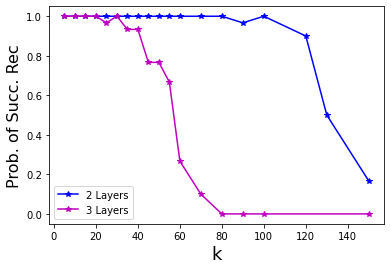

In [41]:
path = './results/experiment_1_v2/'

plt.plot(N0s2, prob_recovery_y_2L, 'b-*', label = '2 Layers')
plt.plot(N0s, prob_recovery_y_3L, 'm-*', label = '3 Layers')
plt.legend(loc = 'best')
plt.xlabel('k', fontsize=18)
plt.ylabel('Prob. of Succ. Rec', fontsize = 16)
plt.savefig(path+'/prob_success.pdf',bbox_inches = 'tight',format='pdf')